# Data understanding

This section is structured as follows:
1. [Collect data](#1-collect-data)
2. [Describe data](#2-describe-data)
3. [Initial explore data](#3-initial-explore-data)
4. [Full search](#4-full-search)

The relevant libraries:

In [1]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from datetime import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt
import credentials as cr

plt.style.use('ggplot')

First you will need a twitter developer account. There are three types of accounts which you can find in the bibliography of the first notebook. In case you do not have a research account, you can opt for a search of tweets in the last 7 days. On the other hand, the research account allows you to access any tweet since the creation of Twitter. Both methods are shown here and used for descriptive and initial data exploratory analysis. From the next notebook the data extracted from the research account will be used.

For privacy reasons, credentials will not be displayed. 

## 1. Collect data

The first thing to do is to establish the credentials and connection with the twitter api. "Credentials" refers those access keys to the twitter developer account. There exists two ways to collect data. 

In [ ]:
#Add your credentials here
twitter_keys = {
  'consumer_key': cr.api_key,
  'consumer_secret': cr.api_secret_key,
  'access_token_key': cr.acces_token,
  'access_token_secret': cr.acces_token_secret   
}

#Setup access to API
auth = tw.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])

# setting the connection with the API
api = tw.API(auth, wait_on_rate_limit=True)

The second step will be to establish three functions: 
- The first will allow to download, in the form of a list, the recents tweets. Filters have been made to delimit tweets related to Medellin and keywords. 
- The second function will allow to convert the list downloaded by the previous function into a dataframe.
- The third function takes care of the structure of text, allowing to save the tweets without making any conflict with the database.

In [ ]:
# Define the search term and the date_since date as variables
def making_the_query(search_query,date_since):

  '''
  recieve two parameters, the key word that we will use to filter the request and 
  the start date (yyyy-mm-dd) to make our query.

  returns a list with all the fetched tweets 
  '''
  query = search_query + ' medellin -filter:retweets' 

  tweets = tw.Cursor(api.search,
                    q=query,
                    lang="es",
                    since=date_since,
                    tweet_mode="extended").items(2)

  list_of_tweets = [[tweet.full_text, 
                    str(tweet.user.screen_name), 
                    tweet.user.location,
                    tweet.created_at,
                    tweet.id,
                    tweet.retweet_count,
                    tweet.favorite_count] for tweet in tweets]
  
  return list_of_tweets

In [1]:
def create_the_df(list_of_tweets):

  '''
  Recieve one parameter, the list with all the tweets and return a dataFrame
  '''

  # creating the dic to fill with the tweets that we fetch
  diccionario = {
      'full_text':[],
      'user':[],
      'location':[],
      'date':[],
      'tweet_id':[],
      'number_rt':[],
      'number_likes':[]
  }

  count = 0
  dict_to_fill = diccionario.copy()

  for row in range(len(list_of_tweets)):
    
    # agregando los datos al diccionario
    dict_to_fill['full_text'].append(list_of_tweets[row][0])
    dict_to_fill['user'].append(str(list_of_tweets[row][1]))
    dict_to_fill['location'].append(list_of_tweets[row][2])
    dict_to_fill['date'].append(list_of_tweets[row][3])
    dict_to_fill['tweet_id'].append(list_of_tweets[row][4])
    dict_to_fill['number_rt'].append(int(list_of_tweets[row][5]))
    dict_to_fill['number_likes'].append(int(list_of_tweets[row][6]))

  df = pd.DataFrame.from_dict(dict_to_fill)

  return df

In [ ]:
def arreglando_texto(texto):

  '''recibe el texto del tweet y lo entrega de forma que no afecta la estructura de los csv'''

  words = texto.split()
  tweet = ''
  for w in words:
    try:
      w_ini = w[:4]
    except:
      w_ini = w
    # filtrando para eliminar los enlaces del tweet
    if w_ini != 'http': tweet+= f' {w}'

  return tweet

Once the key functions have been established, the following will proceed proceed to create a list of keywords extracted from the Medellin development plan, oriented to the line of the plan to be measured. The data will be saved in a csv file for later description and exploration.

In [ ]:
replace_key_words = {
    'movilidad sostenible':'1',
    'movilidad inteligente':'2',
    'servicios publicos':'3',
    'energias alternativas':'4',
    'reciclaje':'5',
    'energias renovables':'6',
    'urbanimo ecologico':'7', 
    'urbanismo':'8', 
    'desarrollo rural':'9',
    'bienestar animal':'10', 
    'biodiversidad':'11', 
    'energias limpias':'12',
    'movilidad':'13',
    'reciclar':'14', 
    'energias':'15', 
    'rural':'16'
}

In [ ]:
# palabras claves seleccionadas para realizar la busqueda
key_words = [
                   '"movilidad sostenible"', '"movilidad inteligente"', '"servicios publicos"',
                   '"energias alternativas"', '"reciclaje"', '"energias renovables"',
                   '"urbanimo ecologico"', '"urbanismo"', '"desarrollo rural"',
                   '"bienestar animal"', '"biodiversidad"', '"energias limpias"',
                   '"movilidad"','"reciclar"', '"energias"', '"rural"',
]

# creando una consulta para cada palabra clave
date_since = "2022-05-21" # date filter to search the tweets
count = 0
for search_query in key_words:

  list_of_tweets = making_the_query(search_query, date_since)
  df = create_the_df(list_of_tweets)
  # creando una nueva columna con la palabra clave
  df['id_key_word'] = search_query.replace('"','')

  if count == 0:
    df_final = df
    count = 1
  else:
    df_final = df_final.append(df, ignore_index=True)

# limpiando la columna con el texto del tweet
df_final['full_text'] = df_final['full_text'].apply(arreglando_texto)
df_final['id_key_word'] = df_final['id_key_word'].replace(replace_key_words)

# using dictionary to convert specific columns  
convert_dict = {
  'user':str,
  'number_likes': int,
  'number_rt': int 
  } 

# convert columns type to match the dataset structure
df_final = df_final.astype(convert_dict) 

In [ ]:
day = date_since[8:10]
month = date_since[5:7]
year = date_since[:4]
df_final.to_csv(f'tweets_{day}{month}{year}.csv',index = False)

For this notebook, two dataframes were saved. They were concatenated together with the keywords in a single data file.

## 2. Describe data

The datasets come from the use of the Twitter API, where we collected information from May 10, 2022 to the present. The tweets are related to keywords, previously defined, that describe one of the strategic lines contemplated in the Medellin Development Plan 2020-2023.
The information contained in this API is received in JSON format, then the data of interest is selected and then saved in .csv files. 

| Syntax      | Description | Test Text     |
| :---        |    :----:   |          ---: |
| Header      | Title       | Here's this   |
| Paragraph   | Text        | And more      |

In [ ]:
df_17052022 = pd.read_csv('data/historic_tweets_17052022.csv')
df_21052022 = pd.read_csv('data/historic_tweets_21052022.csv')
df_key_words = pd.read_csv('data/key_words.csv')

In [ ]:
# everything in one dataFrame
df_tweets = df_17052022.copy()
df_tweets = df_tweets.append(df_21052022, ignore_index=True)
# drop duplicates
df_tweets['tweet_id'] = df_tweets['tweet_id'].astype(int)
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
# adding the key words
df_tweets_key = df_tweets.merge(df_key_words, how='left', on='id_key_word')

In [ ]:
df_tweets_key.head(20)

In [3]:
df_tweets_key.info()

In [4]:
df_tweets_key.describe()

,full_text,user,location,date,tweet_id,number_rt,number_likes,id_key_word
0,Hace 6 años nació @somosmovilidad para promov...,AndresJRendonC,Colombia,2022-05-17 17:22:20,1526614104533830000,6,22,1
1,@MetrodeQuito @efrainbastidasz En el Metro de...,metrodemedellin,"Medellín, Colombia",2022-05-16 23:25:38,1526343144304000000,1,24,1
2,Estuvimos en Medellín visitando el @Areametro...,UKinColombia,Colombia,2022-05-16 20:45:19,1526302800996700000,8,33,1
3,En Medellín ya funciona una flota 100 % eléct...,marcelapedroza,Medellin - Colombia,2022-05-16 17:18:07,1526250657711370000,0,0,1
4,@anabelen20201 @ImparablesEc @andreflores_a @...,WilsonMerinoR,Ecuador,2022-05-13 16:11:31,1525146733801620000,0,3,1
5,Empresarios de @upbcolombia participaron en u...,UPBBogota,NaN,2022-05-12 15:10:59,1524769108738430000,2,2,1
6,@VaneGonzalezMon @QuinteroCalle @juanduquega ...,betitoarias26,NaN,2022-05-18 03:05:18,1526760815486960000,0,0,3
7,@estebanrestre @QuinteroCalle Jajajajaja y en...,DianaVanegasJ,Medellin,2022-05-18 01:45:46,1526740798506660000,0,0,3
8,@estebanrestre @QuinteroCalle Dijo que iba a ...,Juan_Tamayo,"Bogota, Colombia",2022-05-17 21:47:17,1526680781774590000,1,1,3
9,@NoticiasCaracol Los servicios públicos en Me...,AnaMaraSnchezT3,NaN,2022-05-17 20:36:07,1526662871572260000,0,0,3


## 3. Initial explore data

<AxesSubplot:>

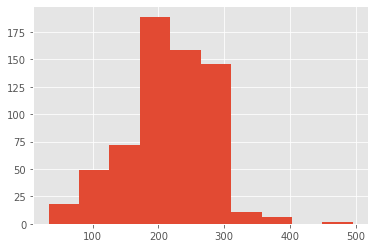

In [8]:
df['full_text'].str.len().hist()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gustavovergara238/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


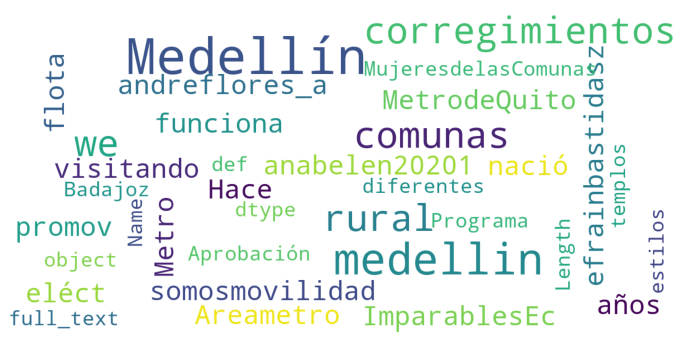

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from wordcloud import WordCloud
stopwords = set(stopwords.words('spanish', 'english'))
text=df['full_text']
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(text))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
 [Text(0, 0, 'Colombia'),
  Text(1, 0, 'Medellín, Colombia'),
  Text(2, 0, 'Medellin - Colombia'),
  Text(3, 0, 'Ecuador'),
  Text(4, 0, 'Medellin'),
  Text(5, 0, 'Bogota, Colombia '),
  Text(6, 0, 'Avenida Siempre Viva 742'),
  Text(7, 0, 'algún lugar del mundo '),
  Text(8, 0, 'Bogotà '),
  Text(9, 0, 'Carabobo, Venezuela'),
  Text(10, 0, 'Envigado'),
  Text(11, 0, 'Colombia '),
  Text(12, 0, ' Colombia '),
  Text(13, 0, 'New York, NY'),
  Text(14, 0, 'Bogotá'),
  Text(15, 0, 'Medellín-Colombia'),
  Text(16, 0, 'NEW YORK & Alaska'),
  Text(17, 0, 'Bogotá, D.C., Colombia'),
  Text(18, 0, 'Marinilla, Colombia'),
  Text(19, 0, 'Buenos Aire

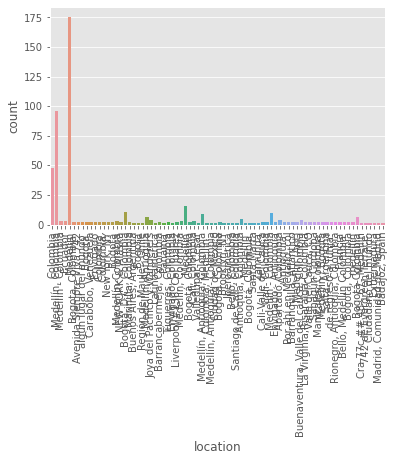

In [10]:
sns.countplot(data=df,x='location')
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='date_modified', ylabel='count'>

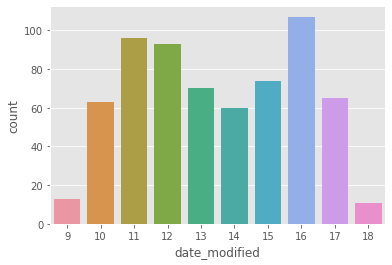

In [11]:
df['date_modified']=pd.to_datetime(df['date']).dt.day
sns.countplot(data=df,x='date_modified')
#plt.xticks(rotation = 90)

<AxesSubplot:xlabel='date_modified', ylabel='count'>

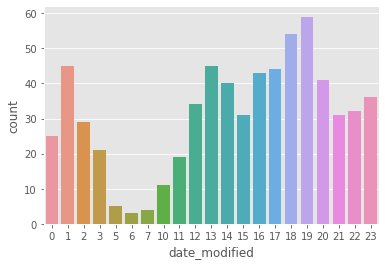

In [12]:
df['date_modified']=pd.to_datetime(df['date']).dt.hour
sns.countplot(data=df,x='date_modified')
#plt.xticks(rotation = 90)

<AxesSubplot:xlabel='date_modified', ylabel='count'>

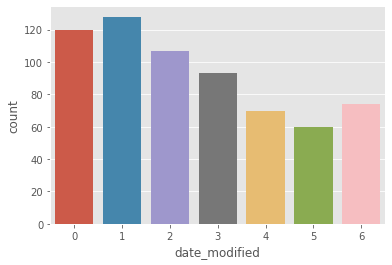

In [13]:
df['date_modified']=pd.to_datetime(df['date']).dt.weekday
sns.countplot(data=df,x='date_modified')
#plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '16'),
  Text(15, 0, '20'),
  Text(16, 0, '28'),
  Text(17, 0, '32'),
  Text(18, 0, '61'),
  Text(19, 0, '134'),
  Text(20, 0, '204'),
  Text(21, 0, '540')])

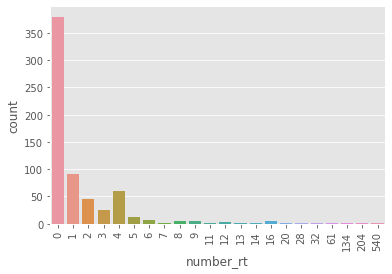

In [14]:
sns.countplot(data=df,x='number_rt')
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='number_likes', ylabel='count'>

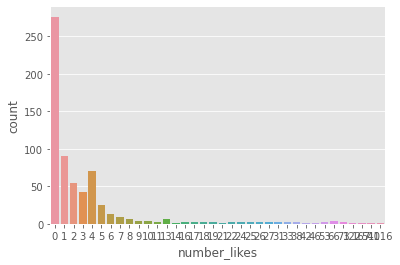

In [15]:
sns.countplot(data=df,x='number_likes')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '1'),
  Text(1, 0, '3'),
  Text(2, 0, '5'),
  Text(3, 0, '8'),
  Text(4, 0, '9'),
  Text(5, 0, '10'),
  Text(6, 0, '11'),
  Text(7, 0, '12'),
  Text(8, 0, 'servicios'),
  Text(9, 0, '13'),
  Text(10, 0, '14'),
  Text(11, 0, '15'),
  Text(12, 0, '16')])

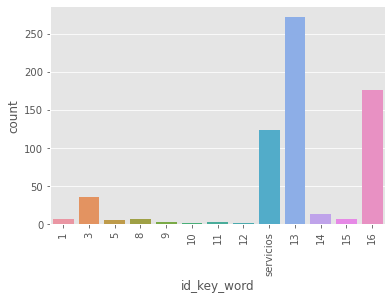

In [16]:
sns.countplot(data=df,x='id_key_word')
plt.xticks(rotation = 90)

## 4. Full search